In [607]:

import numpy as np
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
from copy import deepcopy

# make high resolution figures
mpl.rcParams['figure.dpi'] = 300
##############################################################################
## The Redistricter class implements a MCMC algorithm on Plan objects.
## The details of the algorithm are discussed in class and on Moodle.
##############################################################################
class Redistricter:
    
    def __init__(self):
        self.initial_plan = None
        self.current_plan = None
        self.candidate_plan = None
        self.graph = None
        self.transition_count = 0
        
    def set_initial_plan(self, initial_plan):
        self.initial_plan = initial_plan
        self.current_plan = initial_plan
        # this Plan object is used to propose a transition
        self.candidate_plan = initial_plan
    
    def perform_transition(self):
        
        self.candidate_plan = deepcopy(self.current_plan)
        self.candidate_plan = self.propose_transition(self.current_plan)
        accept = self.consider_transition(self.current_plan, self.candidate_plan)
        if accept == True:
            self.current_plan = deepcopy(self.candidate_plan)
        
    
    def propose_transition(self, plan):

        proposal_plan = deepcopy(plan)
        boundary_nodes = self.find_boundary_nodes(self.current_plan)
        boundary_districts = []

        choose_node = boundary_nodes[random.randint(0,len(boundary_nodes)-1)]
        current_district = proposal_plan.get_district(choose_node)
    
        for i in proposal_plan.get_neighbors(choose_node):
            if i != current_district:
                boundary_districts.append(i)
        choose_district = boundary_districts[random.randint(0,len(boundary_districts)-1)]
        proposal_plan.move_node(choose_node,choose_district)
        return proposal_plan
    
    def consider_transition(self, plan1, plan2):
        p = self.compute_transition_probability(plan1,plan2)
        
        accept = random.choices([True, False] , weights=(p, 1-p))
        return accept[0]

    def find_boundary_nodes(self, plan):
    
        boundary_nodes = []
        for i in plan.cut_edges:
            if i[0] not in boundary_nodes:
                boundary_nodes.append(i[0])
            if i[1] not in boundary_nodes:
                boundary_nodes.append(i[1])
                  
        return boundary_nodes

    
    def compute_transition_probability(self, plan1, plan2):
        prob = len(self.find_boundary_nodes(plan1))/len(self.find_boundary_nodes(plan2))
        if prob > 1:
            prob = 1
        return prob
        
    
    def count_switched_nodes(self, plan1, plan2):
        #
        return
    
##############################################################################
## The Plan class represents one possible redistricting plan
## It can be initialized with an adjacency matrix (csv), node coordinates 
## file (csv), and district assignment file (lists of node id's).
## It contains functions for analyzing node and district connectivity.
## It can check the validity of moving a node to a different district.
## It can move a node between districts if valid.
## It can display a networkx graph diagram of the plan.
##############################################################################
class Plan:
    
    def __init__(self):
        # list from 0 to node count - 1
        self.nodes = []
        # dict {node : (x, y)}
        self.node_coordinates = {}
        # dict {node : (rep, dem, total)}
        self.node_populations = {}
        # list of edge tuples (i, j)
        self.all_edges = []
        # dict {i : [j1, j2, ...]} for each edge (i, j1), (i, j2), ...
        self.edge_dict = {}
        # list of district names of form 'district_i'
        self.districts = []
        # dict {'district_i' : [nodes]}
        self.district_nodes = {}
        # dict {'district_i' : [edge tuples]}
        self.district_edges = {}
        # list of edge tuples crossing district lines
        self.cut_edges = []
        # # nx.DiGraph object for visualization
        # self.plan_graph = None
    
    ##########################################################################
    ## Load an initial plan from file
    ##########################################################################
    # load adjacency matrix from file (csv of 0's and 1's)
    def load_graph_from_file(self, filepath):
        # set self.all_edges from this adjacency matrix
        adj_matrix = []
        with open(filepath) as f:
            for line in f:
                split_line = line.split(",")
                list_line = [int(x) for x in split_line]
                adj_matrix.append(list_line)
        
        # initialize self.nodes
        self.nodes = [i for i in range(len(adj_matrix))]
        
        # populate self.all_edges with tuples (i, j)
        for node, row in enumerate(adj_matrix):
            # initialize edge_dict[node]
            self.edge_dict[node] = []
            for target, val in enumerate(row):
                if val == 1:
                    self.all_edges.append((node, target))
                    self.edge_dict[node].append(target)
        return
    
    # load node coordinates from file (csv of float pairs)
    def load_coordinates_from_file(self, filepath):
        # load coordinates from file and write to a local coords list
        coords = []
        with open(filepath) as f:
            for line in f:
                split_line = line.split(",")
                list_line = [float(x) for x in split_line]
                coords.append((list_line[0], list_line[1]))
        
        # update self.node_coordinates as long as we have the correct number
        if len(coords) != len(self.nodes):
            print("Number of coordinates didn't match number of nodes!")
            return None
        else:
            for node, coord in enumerate(coords):
                self.node_coordinates[node] = coord
        return
    
    # load node party populations from file (csv of population triples)
    def load_populations_from_file(self, filepath):
        # load party ppulations from file and write to a local population list
        party_pops = []
        with open(filepath) as f:
            for line in f:
                split_line = line.split(",")
                list_line = [int(x) for x in split_line]
                party_pops.append((list_line[0], list_line[1], list_line[2]))
        
        # update self.node_populations with tuples (rep, dem, total)
        for i, node in enumerate(self.nodes):
            self.node_populations[node] = party_pops[i]
        return
    
    
    # load initial plan from file (lists of node id's)
    def load_plan_from_file(self, filepath):
        # list to hold counts of number of districts each node is assigned to
        node_matches = [0] * len(self.nodes)
        # read district node lists line by line
        node_lists = []
        with open(filepath) as f:
            for line in f:
                split_line = line.split(",")
                list_line = [int(x) for x in split_line]
                # make sure each node is assigned to exactly one district
                for node in list_line:
                    if node in self.nodes and node_matches[node] == 0:
                        node_matches[node] = 1
                    else:
                        print("Error in node-district membership")
                        print("{}\n{}".format(node, node_matches))
                        return None
                # append list of current nodes to node_lists
                node_lists.append(list_line)
        
        # check every node is assigned
        for match in node_matches:
            if match != 1:
                print("Some node wasn't assigned to a district!")
                return None
        
        # create district names and populate self.districts list
        district_count = len(node_lists)
        self.districts = ["district_{}".format(i) for i in 
                          range(district_count)]
        
        # populate self.district_nodes dict
        for i, district in enumerate(self.districts):
            self.district_nodes[district] = node_lists[i]
        
        # populate self.district_edges dict and cut_edges list
        for district in self.districts:
            # initialize self.district_edges dict
            self.district_edges[district] = []
            # loop through all edges originating in district
            for node in self.district_nodes[district]:
                targets = self.edge_dict[node]
                # append edge to district_edges or cut_edges based on target
                for t in targets:
                    if t in self.district_nodes[district]:
                        self.district_edges[district].append((node, t))
                    else:
                        self.cut_edges.append((node, t))
        return

    ##########################################################################
    ## Node and district connectivity methods
    ##########################################################################
    # get district name of current node
    def get_district(self, node):
        # return districtname such that districtname : node in district_nodes
        for district in self.districts:
            if node in self.district_nodes[district]:
                return district
        return None
    
    # get population of current district in form [rep, dem, total]
    def get_district_population(self, district):
        # form list of rep, dem, total population across all nodes in district
        running_pops = [0, 0, 0]
        for node in self.district_nodes[district]:
            new_pops = self.node_populations[node]
            running_pops = [r + n for r,n in zip(running_pops, new_pops)]
        return running_pops
    
    # get neighbors of current node, return dict {district : node_list}
    def get_neighbors(self, node):
        neighbor_dict = {}
        # use self.edge_dict to get all connected nodes
        targets = self.edge_dict[node]
        # use get_district to form neighbor_dict
        for t in targets:
            dist = self.get_district(t)
            # append t to neighbor_dict[dist] or initialize with [t]
            if dist in neighbor_dict.keys():
                neighbor_dict[dist].append(t)
            else:
                neighbor_dict[dist] = [t]
        
        # return dict {district : [neighboring nodes]}
        return neighbor_dict
    
    # check list of nodes is all in the same district and all connected
    def check_connected(self, node_list):
        # use get_district and district_nodes to confirm all in same district
        district = self.get_district(node_list[0])
        for node in node_list:
            if self.get_district(node) != district:
                print("Nodes are not all in same district!")
                return None
        
        # create dict {i : [j1, j2, ...]} for node connectivity in district
        district_edge_dict = {node : [] for node in 
                              self.district_nodes[district]}
        # append all target nodes to each district_edge_dict[node]
        for edge in self.district_edges[district]:
            district_edge_dict[edge[0]].append(edge[1])
        
        # use district_edge_dict to confirm connectivity iteratively
        # starting with node_list[0], must target at least one neighbor
        # if you can't find another neighbor in a single step, return False
        current_nodes = [node_list[0]]
        nodes_left = node_list[1:]
        while len(nodes_left) > 0:
            next_nodes = []
            for target in nodes_left:
                for node in current_nodes:
                    if target in district_edge_dict[node]:
                        next_nodes.append(target)
            # remove duplicates from list of next nodes
            next_nodes = list(set(next_nodes))
            
            # if no new neighbors reached, district is not simply connected!
            if next_nodes == []:
                return False
            # else, update current_nodes and remove these from nodes_left
            else:
                current_nodes = next_nodes
                nodes_left = [n for n in nodes_left if n not in next_nodes]
        
        # completed while loop so nodes_left == [] and all nodes reached
        return True
    
    # compute Gibbs distribution for this Plan
    def compute_gibbs_distribution(self, beta=5.0):
        # form list of district population data
        dist_pops = []
        for dist in self.districts:
            # append total population in the current district
            dist_pops.append(self.get_district_population(dist)[2])
        avg_pop = float(sum(dist_pops)) / len(self.districts)
        
        # compute equal population constraint by comparing districts to avg
        total = 0
        for pop in dist_pops:
            total += abs(pop / avg_pop - 1)
        
        # return non-normalized Gibbs distribution
        return np.exp(-beta*total)
    
    # compute electoral competitiveness for this Plan
    def compute_electoral_competitiveness(self, alpha=1, beta=4/3):
        # form list of district population data
        full_dist_pops = []
        for dist in self.districts:
            # append population data from the current district
            full_dist_pops.append(self.get_district_population(dist))
        
        # compute T_p and T_e in the EC formula
        vote_share_sum = 0
        seat_share_sum = 0
        for pop in full_dist_pops:
            vote_share_sum += abs(float(pop[0]) / pop[2] - 0.5)
            if pop[0] > pop[1]:
                seat_share_sum += 1
            elif pop[0] == pop[1]:
                seat_share_sum += 0.5
        vote_share = vote_share_sum / len(full_dist_pops)
        seat_share = abs(seat_share_sum / len(full_dist_pops) - 0.5)
        
        # return Tam Cho and Lin EC formula
        ec = 1 - vote_share * (1 + alpha * seat_share) * beta
        return ec
        
    ##########################################################################
    ## Cleanup method when accepting a candidate
    ##########################################################################
    # move node to new district and update all edge dicts and lists
    def move_node(self, node, district):
        # check node isn't in district
        if node in self.district_nodes[district]:
            print("Node is in the specified district already!")
            return False
        
        # check node is connected to district
        neighbors = self.get_neighbors(node)
        if district not in neighbors.keys():
            print("Node isn't connected to specified district!")
            return False
        
        # find all edges from node within old district, and to new district
        old_district = self.get_district(node)
        # track old neighbors for testing connectivity later
        old_neighbors = []
        internal_edges = []
        crossing_edges = []
        # move is invalid if node was the last member of old_district
        if old_district not in neighbors.keys():
            return False
        for target in neighbors[old_district]:
            old_neighbors.append(target)
            internal_edges.append((node, target))
            internal_edges.append((target, node))
        for target in neighbors[district]:
            crossing_edges.append((node, target))
            crossing_edges.append((target, node))
        
        # update district_nodes to move node
        self.district_nodes[district].append(node)
        self.district_nodes[old_district].remove(node)
        
        # move cut edges to district_edges of district
        for edge in crossing_edges:
            self.district_edges[district].append(edge)
            self.cut_edges.remove(edge)
        
        # move old edges to cut edges
        for edge in internal_edges:
            self.cut_edges.append(edge)
            self.district_edges[old_district].remove(edge)
        
        # the node was successfully moved
        # check that old_neighbors remain connected in old district
        is_connected = self.check_connected(old_neighbors)
        return is_connected
    
    ##########################################################################
    ## Visualization
    ##########################################################################
    # visualize DiGraph
    def show_plan(self):        
        G = nx.DiGraph()
        G.add_nodes_from(self.nodes)
        # add within-district edges to G
        for district in self.districts:
            G.add_edges_from(self.district_edges[district], 
                             color='black', weight=1.0)
        
        # define default colors and weights to edges of G
        colors = nx.get_edge_attributes(G, 'color').values()
        weights = nx.get_edge_attributes(G, 'weight').values()
        
        # include cut edges in dotted red style in a separate graph H
        H = nx.DiGraph()
        H.add_nodes_from(G)
        for edge in self.cut_edges:
            H.add_edge(*edge, color='r', weight=0.2)
        colors_cut = nx.get_edge_attributes(H, 'color').values()
        weights_cut = nx.get_edge_attributes(H, 'weight').values()
        
        # possibly assign colors to districts
        
        # draw nodes, node labels, district edges, and cut edges
        nx.draw_networkx_nodes(G, self.node_coordinates, label = True, 
                               node_size = 150, node_shape = 'o')
        nx.draw_networkx_labels(G, self.node_coordinates, font_size = 8)
        nx.draw_networkx_edges(G, self.node_coordinates, edge_color=colors,
                               width=list(weights), arrows = False,)
        nx.draw_networkx_edges(H, self.node_coordinates, 
                               edge_color = colors_cut,
                               width = list(weights_cut), arrows = False, 
                               style = 'dotted')
        
        # display the finished map
        plt.show()
        return














#

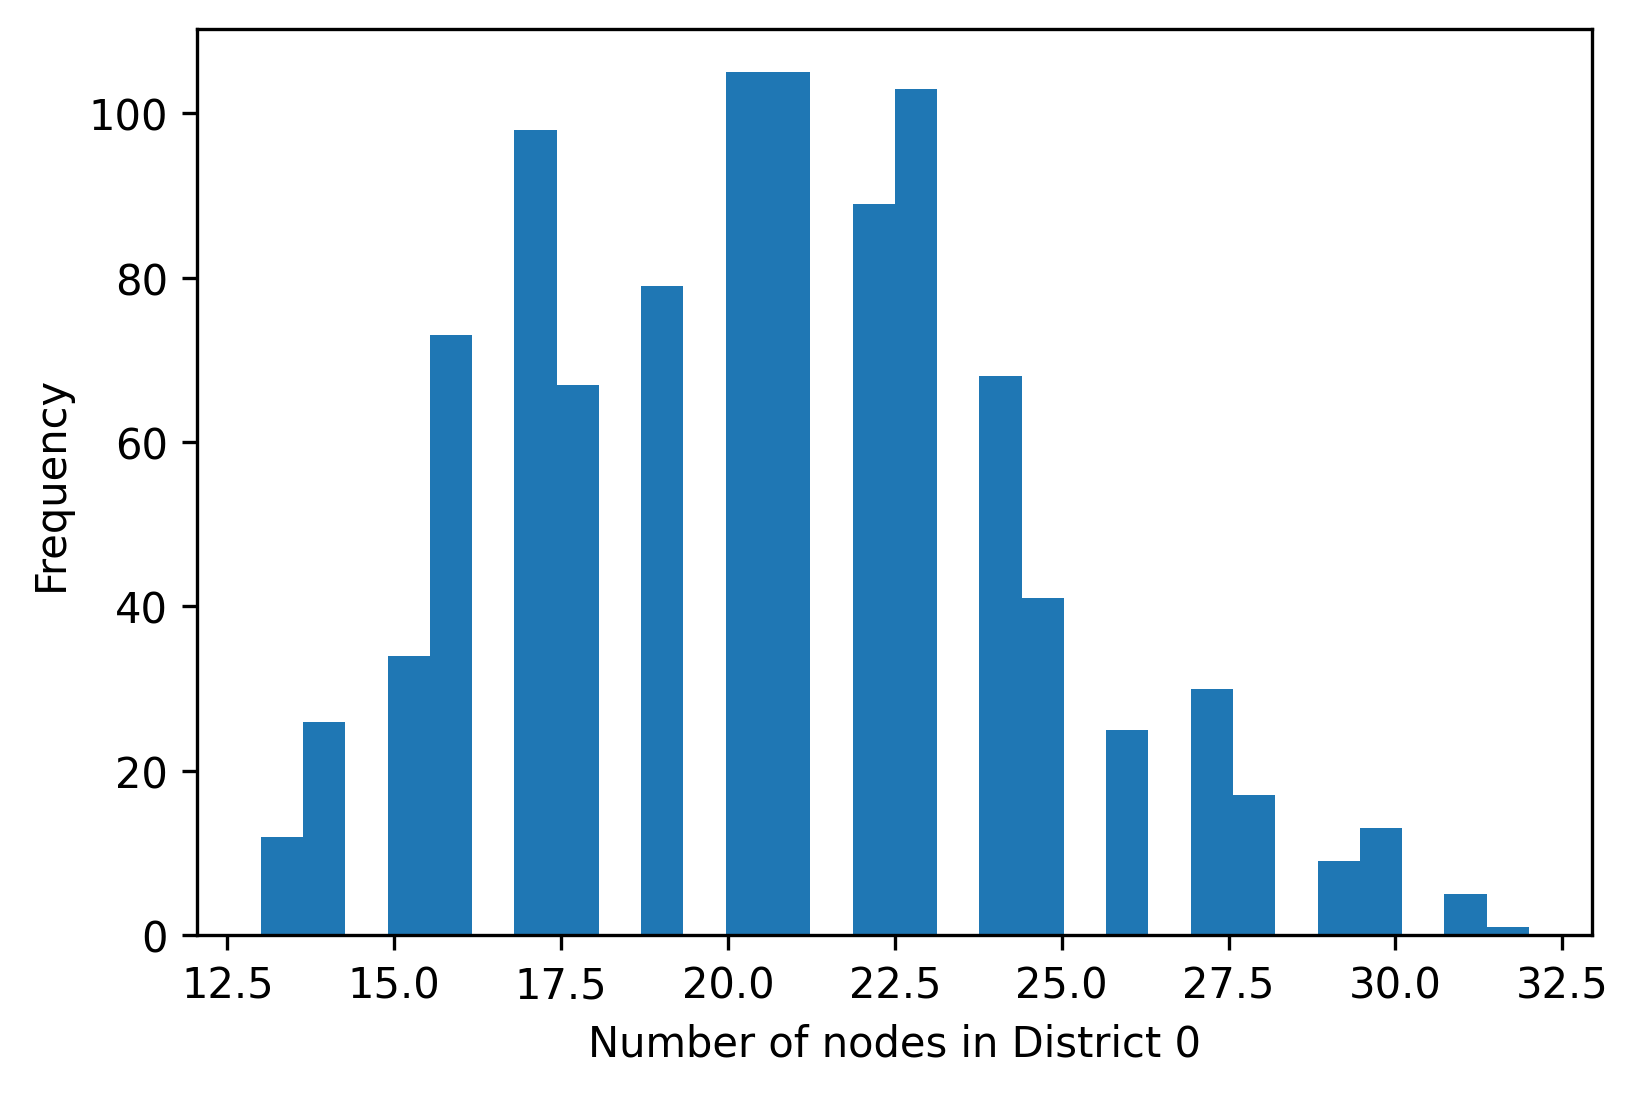

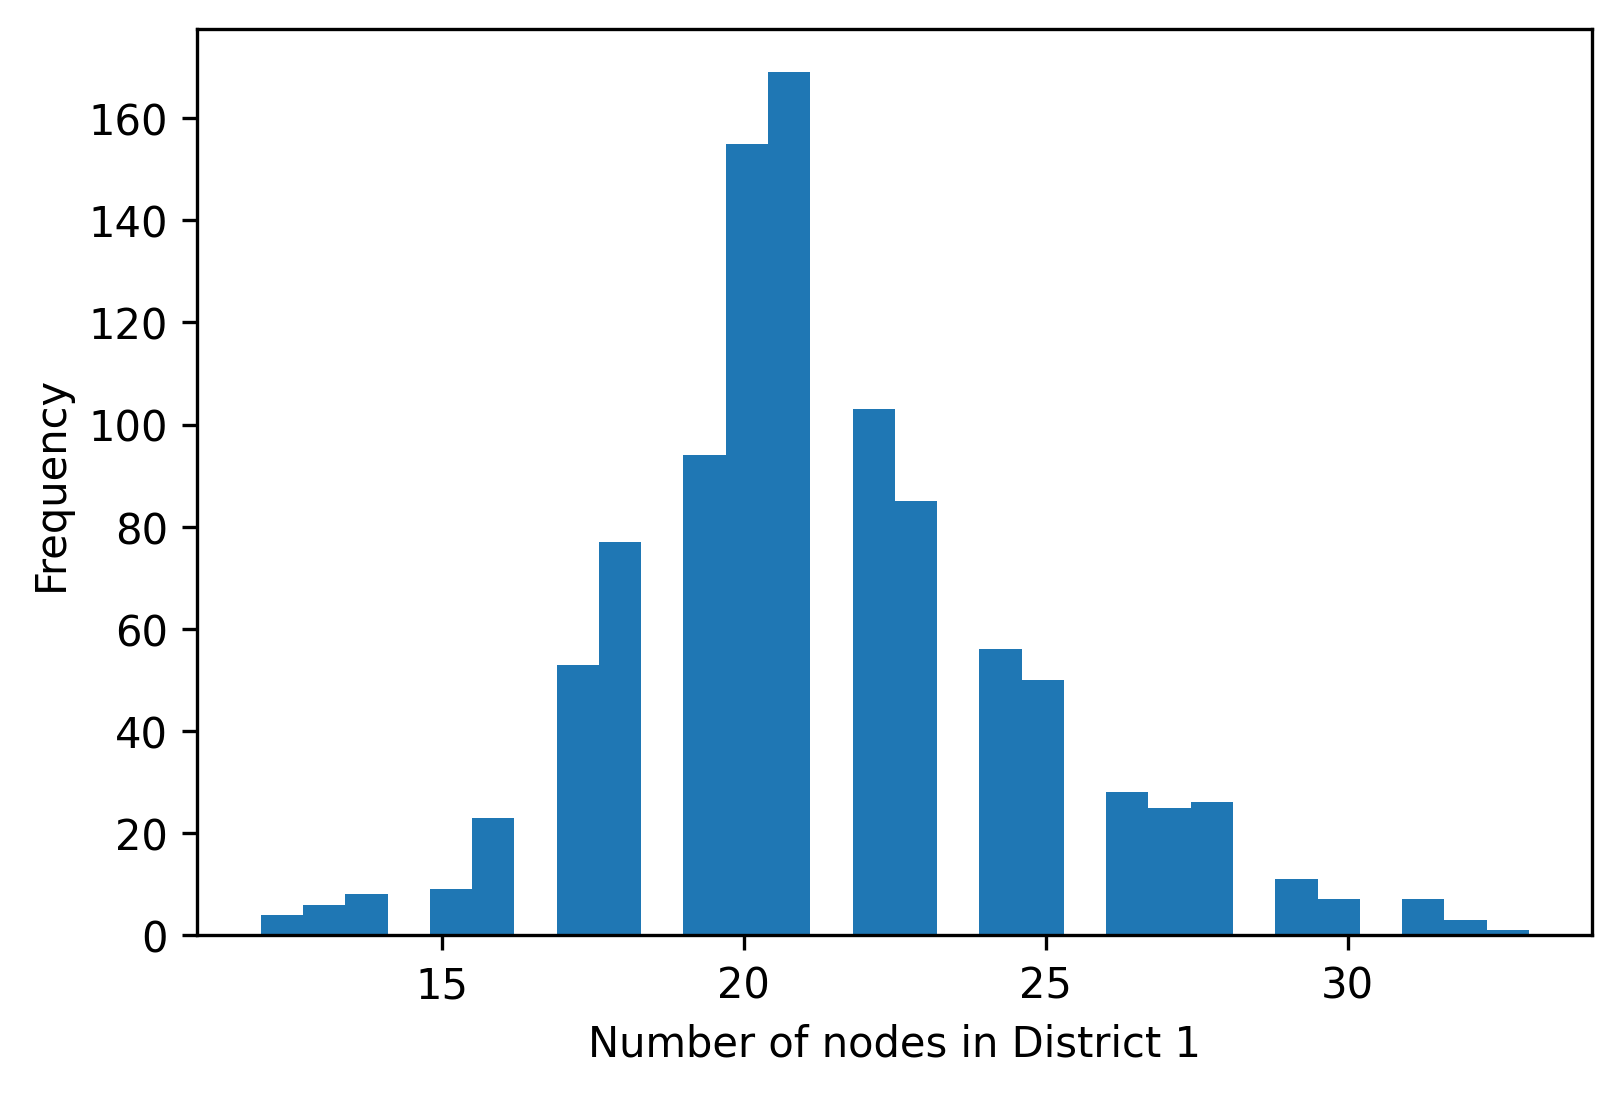

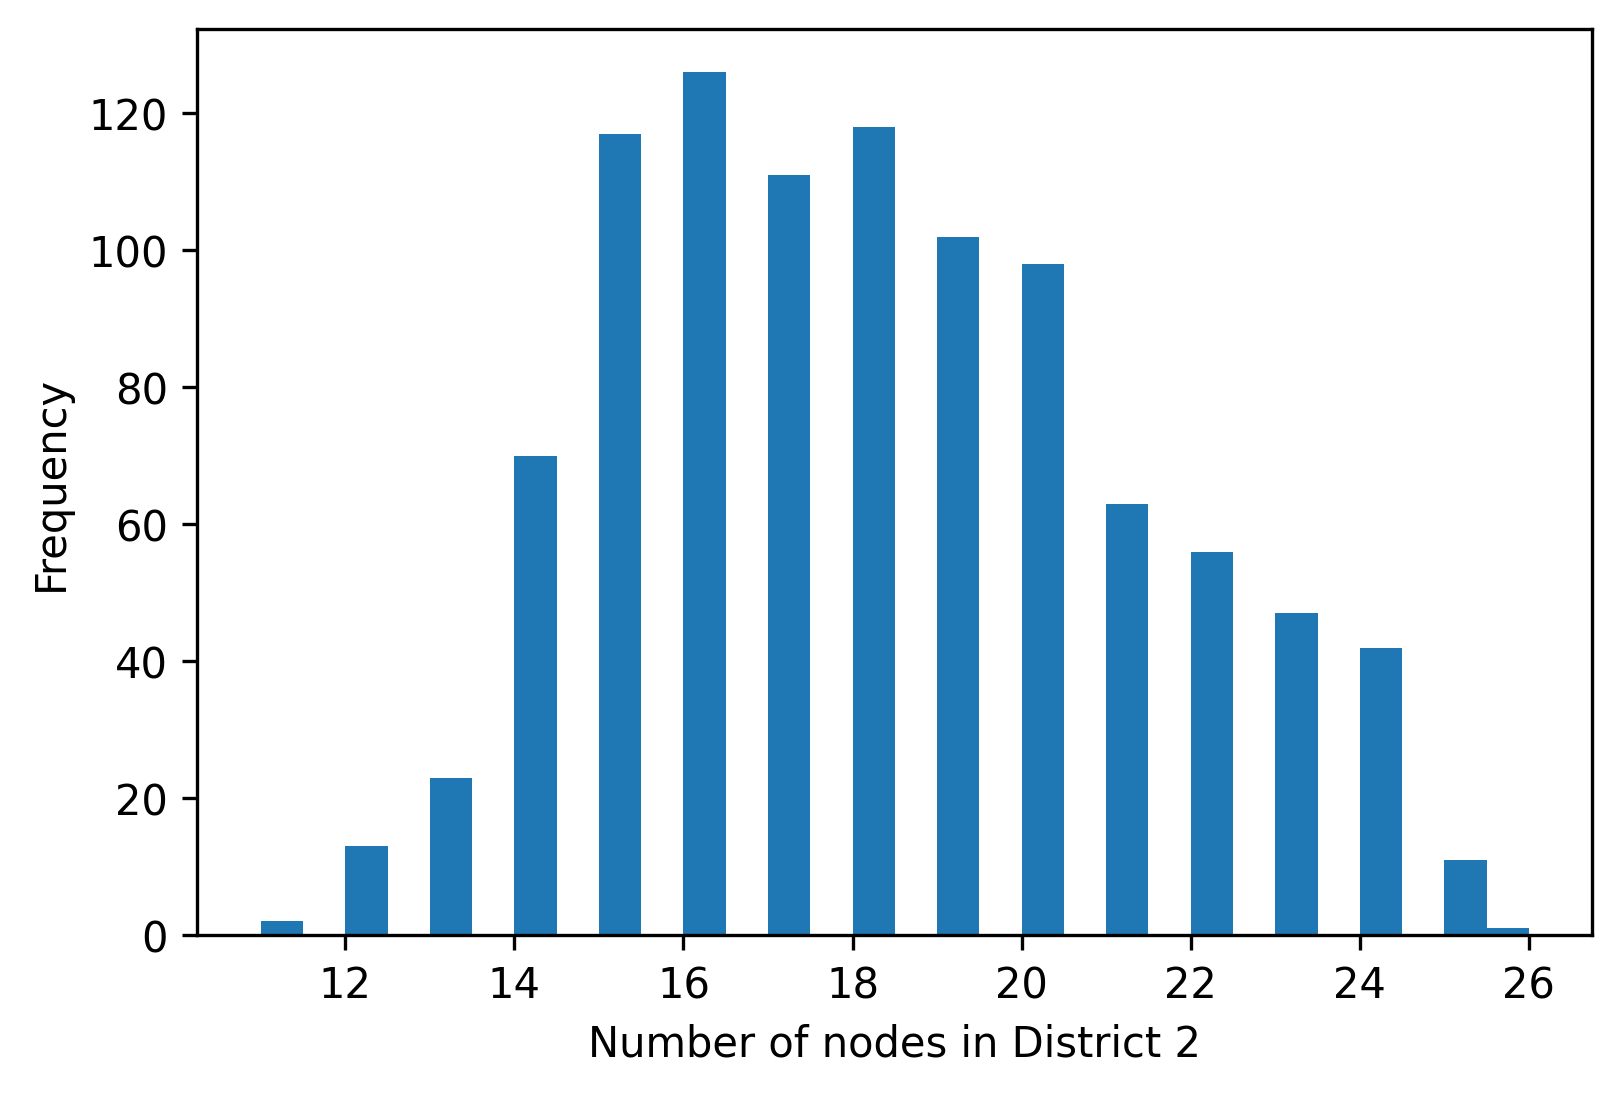

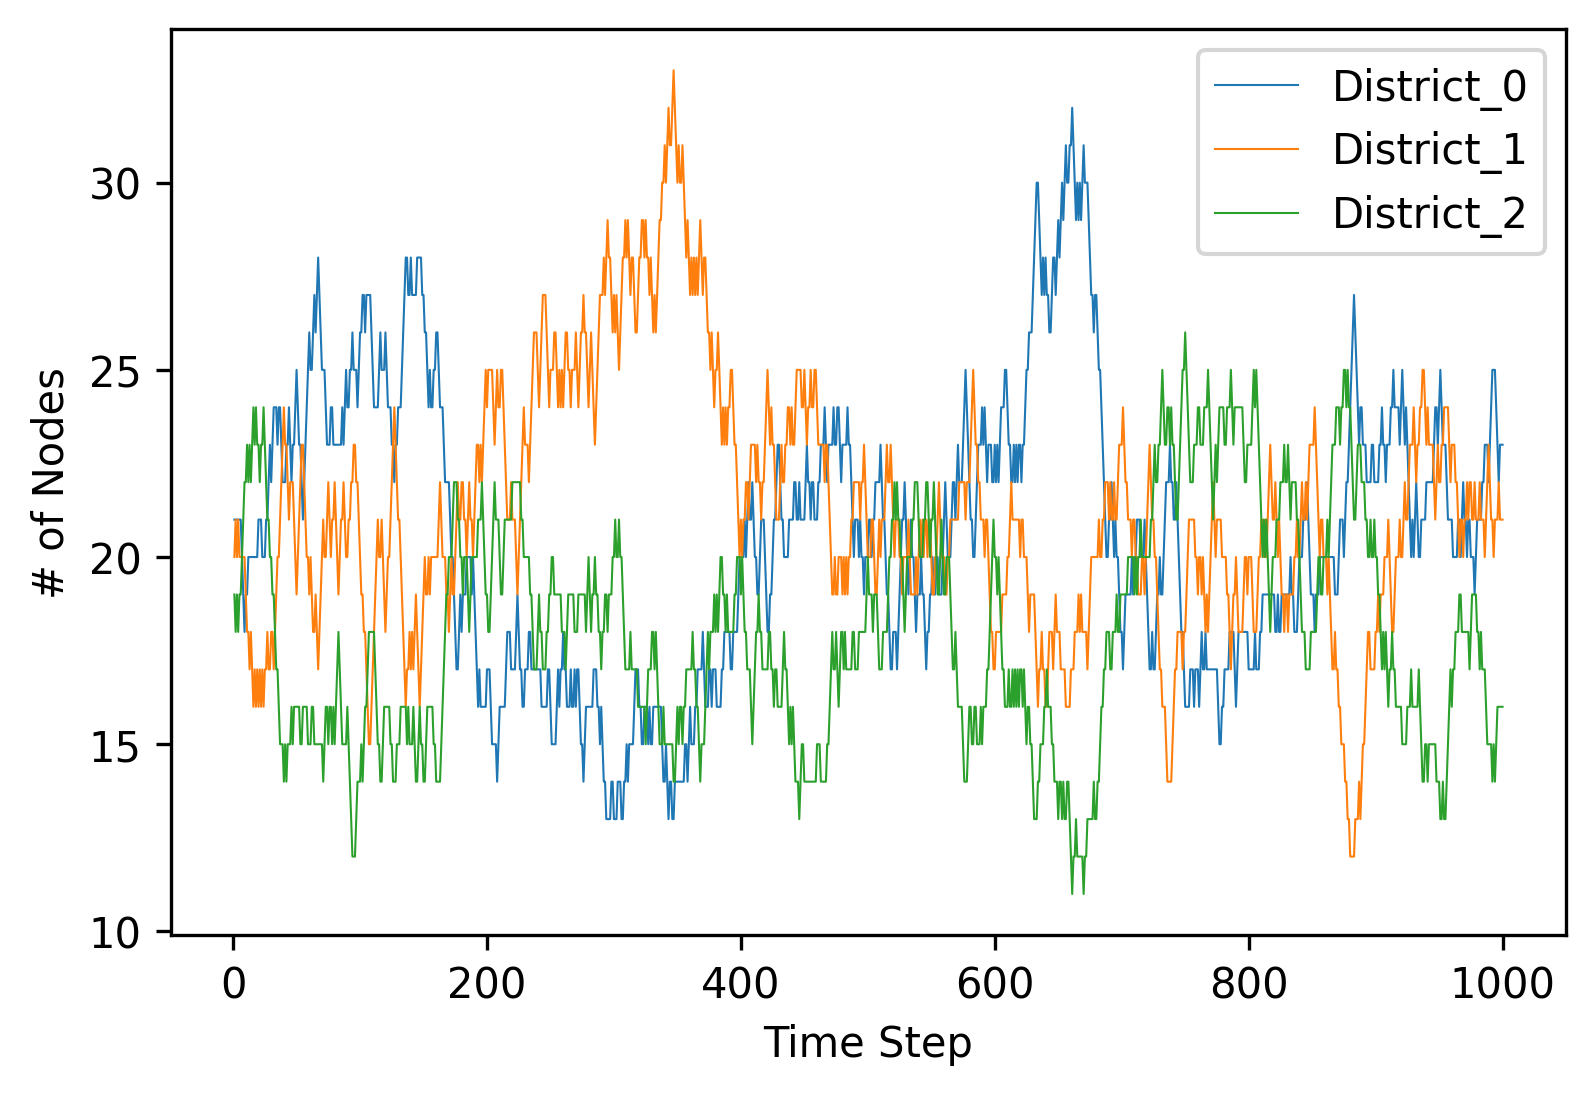

In [608]:
##############################################################################
## The main() function is where all your commands go.
## So far all it does is load the three data files and visualize the Plan.
##############################################################################
def main():
    # create a folder named data in the same folder as the source code and
    # place the three data files there.
    ADJ_MATRIX_PATH = "adjacency_matrix.txt"
    COORDINATES_PATH = "coordinates.txt"
    PARTY_POP_PATH = "party_pop.txt"
    DISTRICT_ASSIGNMENT_PATH = "district_assignment.txt"
    
    initial_plan = Plan()
    initial_plan.load_graph_from_file(ADJ_MATRIX_PATH)
    initial_plan.load_coordinates_from_file(COORDINATES_PATH)
    initial_plan.load_populations_from_file(PARTY_POP_PATH)
    initial_plan.load_plan_from_file(DISTRICT_ASSIGNMENT_PATH)
    
    
    district_count=np.zeros(3000).reshape(1000,3)
    
    
    plan = Redistricter()
    plan.set_initial_plan(initial_plan)
    plan_array = np.zeros(1000)
    
    for t in range(1000):
        
        plan.perform_transition()
        values = plan.current_plan.district_nodes.values()
        for i,j in enumerate(values):
            district_count[t,i] = len(j)
    
    # Histograms
    plt.hist(district_count[:,0],bins=30)
    plt.xlabel('Number of nodes in District 0')
    plt.ylabel('Frequency')
    plt.show() 
    plt.hist(district_count[:,1],bins=30)
    plt.xlabel('Number of nodes in District 1')
    plt.ylabel('Frequency')
    plt.show()
    plt.hist(district_count[:,2],bins=30)
    plt.xlabel('Number of nodes in District 2')
    plt.ylabel('Frequency')
    plt.show()
    
    # Graphs
    
    # District_0
    y = np.arange(1000).reshape(1000,1) + 1
    z = np.concatenate((y,district_count), axis = 1)
    plt.plot(z[:,0], z[:,1], linewidth=0.5, label ='District_0')
    
    # District_1
    plt.plot(z[:,0], z[:,2], linewidth=0.5, label ='District_1')
    
    # District_2
    plt.plot(z[:,0], z[:,3], linewidth=0.5, label ='District_2')
    
    plt.xlabel("Time Step")
    plt.ylabel("# of Nodes")
    plt.legend()
    plt.show()

    ## How to tune beta?
    # run Redistricter 5000 times
    # possible move: compute P_v for each of the 5000 plans
    # for this, adapt the Gibbs distribution method
    # alternative move: note the minimum district size (# nodes) in each plan


##############################################################################
## Run the main() function
##############################################################################

if __name__ == "__main__":
    main()




In [586]:
x = np.ones(2000).reshape(1000,2)
y = np.arange(1000).reshape(1000,1) + 1
z = np.concatenate((y,x), axis = 1)
z

array([[   1.,    1.,    1.],
       [   2.,    1.,    1.],
       [   3.,    1.,    1.],
       ...,
       [ 998.,    1.,    1.],
       [ 999.,    1.,    1.],
       [1000.,    1.,    1.]])